In [1]:
!pip install numpy pandas scikit-learn tensorflow matplotlib

In [8]:
# decision why: we store CMAPSS files on Google Drive so every team member can access the same data version.

from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
DATA_DIR = Path("/content/drive/MyDrive/FD002")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# decision why: Check dataset folder and list files,verifying the folder structure ensures all required CMAPSS files (train, test, RUL) are present before loading.

from pathlib import Path
DATA_DIR = Path("/content/drive/MyDrive/FD002")
FD = "FD002"

!ls -lh /content/drive/MyDrive/FD002

total 15M
-rw------- 1 root root 1.1K Oct  1  2008 RUL_FD002.txt
-rw------- 1 root root 5.5M Sep 17  2008 test_FD002.txt
-rw------- 1 root root 8.7M Sep 17  2008 train_FD002.txt


In [10]:
# decision why: load data and naming, adding explicit column names (unit, cycle, ops, sensors) improves readability and avoids confusion during analysis.

import pandas as pd

col_names = ["unit", "cycle", "op1", "op2", "op3"] + [f"s{i}" for i in range(1,22)]
train = pd.read_csv(DATA_DIR / f"train_{FD}.txt", sep=r"\s+", header=None, names=col_names)
test  = pd.read_csv(DATA_DIR / f"test_{FD}.txt",  sep=r"\s+", header=None, names=col_names)
rul   = pd.read_csv(DATA_DIR / f"RUL_{FD}.txt",   sep=r"\s+", header=None, names=["RUL"])

train.head()

,unit,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


In [11]:
# decision why: We compute RUL for the training set.Calculating RUL gives each engine's remaining cycles until failure, and capping at 125 stabilizes model training.

import numpy as np

RUL_CAP = 125
USE_RUL_CAP = True

def add_train_rul(df, cap=None):
    df = df.copy()
    max_cycle = df.groupby("unit")["cycle"].max().rename("max_cycle")
    df = df.merge(max_cycle, on="unit", how="left")
    df["RUL"] = df["max_cycle"] - df["cycle"]
    if cap is not None:
        df["RUL"] = np.minimum(df["RUL"], cap)
    return df.drop(columns=["max_cycle"])

train_lbl = add_train_rul(train, cap=RUL_CAP if USE_RUL_CAP else None)

display(train_lbl.head())
print("train_lbl shape:", train_lbl.shape)
print("RUL min/max:", train_lbl["RUL"].min(), train_lbl["RUL"].max())

,unit,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,125
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,125
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,125
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,125
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,125


train_lbl shape: (53759, 27)
RUL min/max: 0 125


In [17]:

# decision why: We build test set labels with RUL_FD002.txt, test data stops before failure, so we extend each engine's last known RUL from RUL_FD002 to compute full labels.

import numpy as np
import pandas as pd

if "RUL_CAP" not in globals():
    RUL_CAP = 125
if "USE_RUL_CAP" not in globals():
    USE_RUL_CAP = True

test_last = (
    test.groupby("unit")["cycle"]
        .max()
        .reset_index()
        .rename(columns={"cycle": "max_cycle"})
)

test_m = (
    test.merge(test_last, on="unit", how="left")
        .sort_values(["unit", "cycle"])
        .reset_index(drop=True)
)

n_units = test_m["unit"].nunique()
assert len(rul) == n_units, f"Mismatch: RUL rows={len(rul)} vs test units={n_units}"

unit_order = test_m["unit"].unique()
final_rul_map = dict(zip(unit_order, rul["RUL"].values))
test_m["final_RUL"] = test_m["unit"].map(final_rul_map)

test_m["RUL"] = (test_m["final_RUL"] + (test_m["max_cycle"] - test_m["cycle"])).astype(int)

if USE_RUL_CAP:
    test_m["RUL"] = np.minimum(test_m["RUL"], RUL_CAP)

test_lbl = test_m.drop(columns=["final_RUL"])

display(test_lbl.head(8))
print("test_lbl shape:", test_lbl.shape)
print("RUL range: ", int(test_lbl["RUL"].min()), "to", int(test_lbl["RUL"].max()))
print("Units (test):", test_lbl["unit"].nunique(), " | RUL rows:", len(rul))

,unit,cycle,op1,op2,op3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,max_cycle,RUL
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551,258,125
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039,258,125
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125,258,125
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181,258,125
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740,258,125
5,1,6,25.0006,0.6206,60.0,462.54,536.62,1258.90,1047.35,7.05,...,7859.98,10.9378,0.02,307,1915,84.93,14.26,8.4941,258,125
6,1,7,42.0017,0.8400,100.0,445.00,549.47,1351.28,1124.43,3.91,...,8069.15,9.3595,0.02,330,2212,100.00,10.57,6.3555,258,125
7,1,8,41.9994,0.8404,100.0,445.00,549.49,1349.20,1126.95,3.91,...,8068.88,9.3753,0.02,330,2212,100.00,10.67,6.2992,258,125


test_lbl shape: (33991, 28)
RUL range:  6 to 125
Units (test): 259  | RUL rows: 259


In [19]:
# decision why: select failure and remove near-constant sensors to reduce noise, and add first-order differences (_d1) to capture degradation trends over time.

sensor_cols = [c for c in test_lbl.columns if c.startswith("s")]
keep_sensors = [c for c in sensor_cols if train_lbl[c].std() > 1e-3]

feature_cols = ["op1","op2","op3"] + keep_sensors

def add_deltas(df, cols):
    df = df.sort_values(["unit","cycle"]).copy()
    for c in cols:
        df[c+"_d1"] = df.groupby("unit")[c].diff().fillna(0.0)
    return df

train_feat = add_deltas(train_lbl, keep_sensors)
test_feat  = add_deltas(test_lbl,  keep_sensors)

feature_cols = feature_cols + [c+"_d1" for c in keep_sensors]

print("Sensors kept:", len(keep_sensors))
print("Total features:", len(feature_cols))

Sensors kept: 21
Total features: 45


In [25]:
# decision why: cluster.FD002 has multiple operating conditions; clustering by op1–op3 and scaling within each cluster avoids mixing different regimes.

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

SEED = 42
np.random.seed(SEED)

K = 4
kmeans = KMeans(n_clusters=K, random_state=SEED, n_init="auto")
train_feat["cluster"] = kmeans.fit_predict(train_feat[["op1","op2","op3"]])
test_feat["cluster"]  = kmeans.predict(test_feat[["op1","op2","op3"]])

scalers = {}
for k in range(K):
    scaler = StandardScaler()
    idx = (train_feat["cluster"] == k)
    scaler.fit(train_feat.loc[idx, feature_cols])
    scalers[k] = scaler

def scale_by_cluster(df, feature_cols, scalers):
    X = np.zeros((len(df), len(feature_cols)), dtype=np.float32)
    for k, scaler in scalers.items():
        idx = (df["cluster"] == k)
        X[idx] = scaler.transform(df.loc[idx, feature_cols])
    return X

X_train_all = scale_by_cluster(train_feat, feature_cols, scalers)
y_train_all = train_feat["RUL"].values.astype(np.float32)

X_test_all  = scale_by_cluster(test_feat, feature_cols, scalers)
y_test_all  = test_feat["RUL"].values.astype(np.float32)

print("X_train_all:", X_train_all.shape, "| X_test_all:", X_test_all.shape)
print("y ranges — train:", (y_train_all.min(), y_train_all.max()),
      " test:", (y_test_all.min(), y_test_all.max()))

X_train_all: (53759, 45) | X_test_all: (33991, 45)
y ranges — train: (np.float32(0.0), np.float32(125.0))  test: (np.float32(6.0), np.float32(125.0))


In [23]:
# decision why: evaluate using MAE, RMSE, and NASA score to measure prediction accuracy and penalize underestimation of RUL more strongly.

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

pred_rf = rf.predict(X_test)

mae  = mean_absolute_error(y_test, pred_rf)
rmse = mean_squared_error(y_test, pred_rf) ** 0.5

def nasa_score(y_true, y_pred):
    d = y_pred - y_true
    s_pos = np.exp(d[d>=0]/13.0) - 1.0
    s_neg = np.exp(-d[d<0]/10.0) - 1.0
    return s_pos.sum() + s_neg.sum()

score = nasa_score(y_test, pred_rf)

print(f"RandomForest MAE  = {mae:.3f}")
print(f"RandomForest RMSE = {rmse:.3f}")
print(f"RandomForest NASA = {score:.3f}")

RandomForest MAE  = 14.807
RandomForest RMSE = 19.174
RandomForest NASA = 371695.190


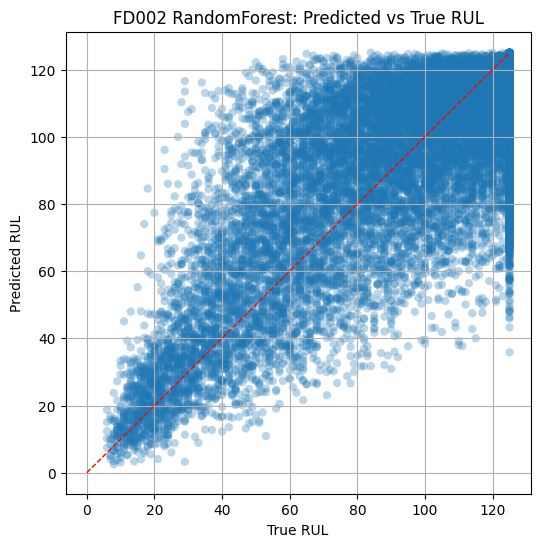

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, pred_rf, alpha=0.3, edgecolor="none")
m = max(y_test.max(), pred_rf.max())
plt.plot([0, m], [0, m], 'r--', linewidth=1)
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("FD002 RandomForest: Predicted vs True RUL")
plt.grid(True)
plt.show()